## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calculate distortion coefficients, and test undistortion on an image

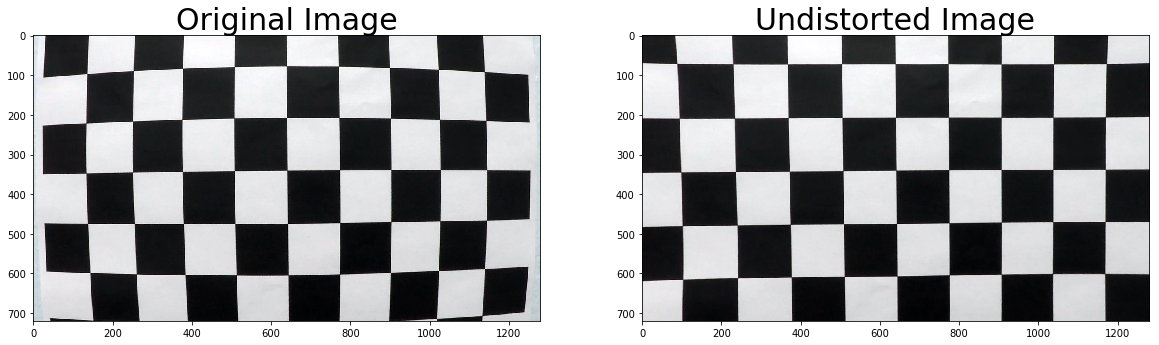

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Pipeline

### 1.Use the camera calibration result we got to undistort image

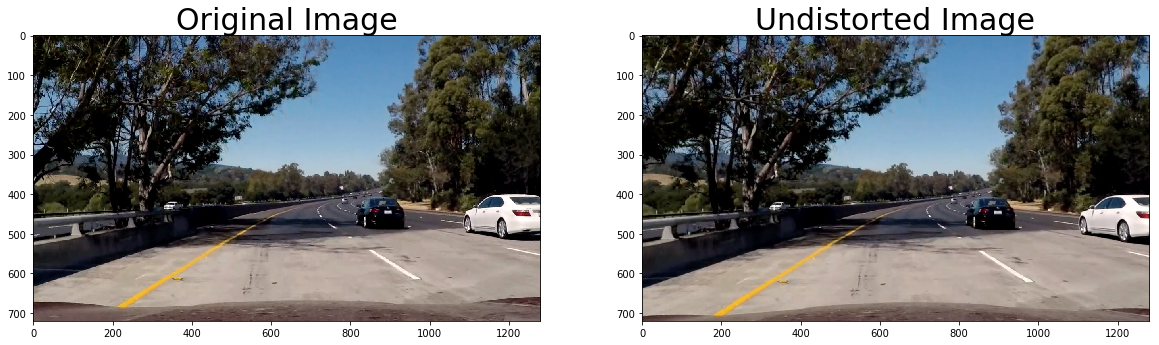

In [145]:
import pickle
 
    
# load the camera calibration result
with open("./dist_pickle.p", mode='rb') as f:
    dist_pickle = pickle.load(f)

mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]

def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
# read a test image
img = cv2.imread('../test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_size = (img.shape[1], img.shape[0])

# undistort the image
undist_image = undist(img)

cv2.imwrite('../output_images/test5_undist.jpg',undist_image)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Create a thresholded binary image

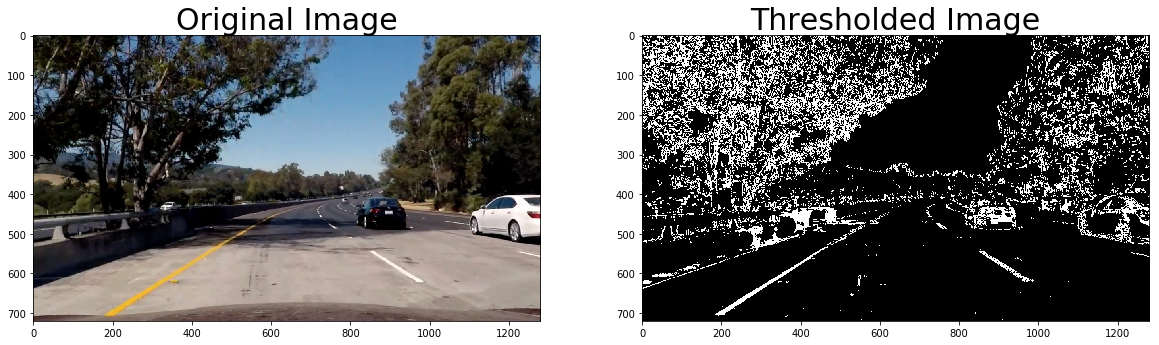

In [167]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


# read a test image
img = cv2.imread('../output_images/test5_undist.jpg')

img_size = (img.shape[1], img.shape[0])

# undistort the image
threshold_img = threshold(img)
cv2.imwrite('../output_images/test5_thresholded.jpg',threshold_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(threshold_img, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=30)

### 3. Perspective transform

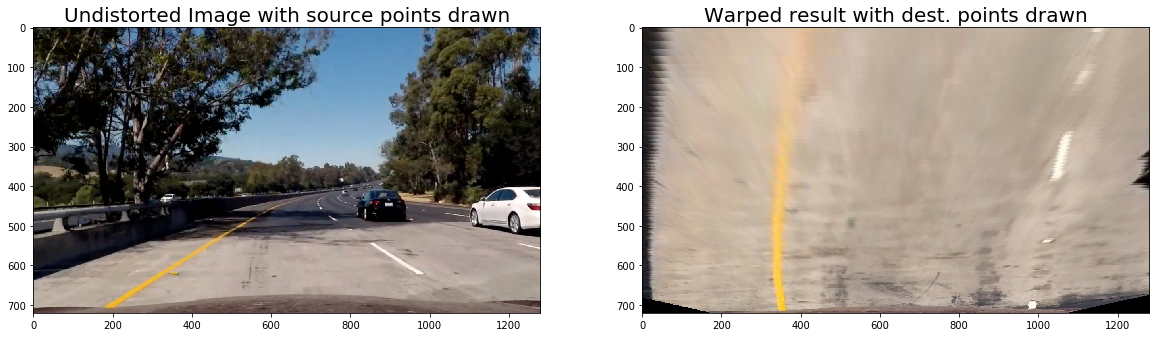

In [107]:
# read a test image
img = cv2.imread('../output_images/test5_undist.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# hardcode the source and destination points
src_points = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst_points = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


M = cv2.getPerspectiveTransform(src_points, dst_points)

def perspective(img):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


# wrap the image
perspective_img = perspective(image)

# output the image
cv2.imwrite('../output_images/test5_wraped.jpg',perspective_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(perspective_img)
ax2.set_title('Warped result with dest. points drawn', fontsize=20)

### 4. Find the lane line

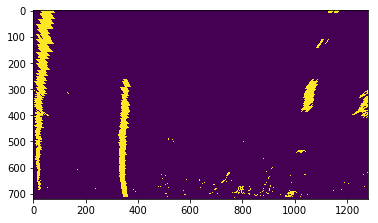

(720, 0)

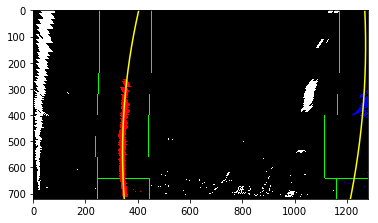

In [165]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# read a test image
img = cv2.imread('../output_images/test1_undist.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# threshold
threshold_img = threshold(img)

perspective_img = perspective(threshold_img)

#print(binary_warped.shape)

plt.imshow(perspective_img)
plt.show()

def get_lane_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty 

leftx, lefty, rightx, righty = get_lane_lines(perspective_img)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 5. Calculate the radius of curvature 

In [109]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1490.16867259 51069.7350834
470.853374841 m 16043.6072575 m


### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly

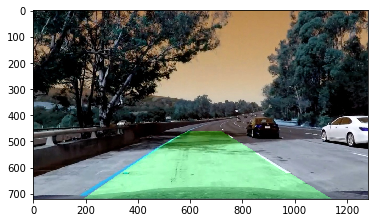

In [110]:
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

def draw_lane_line(img, left_fitx, right_fitx, ploty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

leftx, lefty, rightx, righty = get_lane_lines(perspective(threshold(img)))

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

final_img = draw_lane_line(img, left_fitx, right_fitx, ploty)

plt.imshow(final_img)

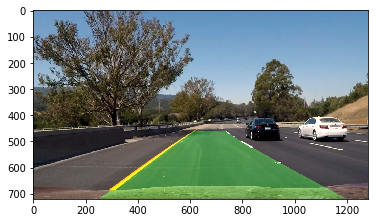

In [161]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=5) 
        
        self.recent_fitted = deque([],maxlen=5)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.yvals = None
    
    def set_diffs(self):
        if len(self.recent_xfitted) > 0 and self.best_fit is not None:
            self.diffs = self.current_fit - self.best_fit
        else:
            self.diffs = np.array([0,0,0], dtype='float')    
            
    def set_line_pos_pos(self):
        y_max = 720
        line_pos = self.current_fit[0]*y_max**2 + self.current_fit[1]*y_max + self.current_fit[2]
        center_pos = 640
        self.line_base_pos =(line_pos - center_pos)*3.7/600.0 # 3.7 meters is about 600 pixels       
    
    def sanity_check(self):
        flag = True
#         min_lane_width  = 3.5
#         if(abs(self.line_base_pos)*2 < min_lane_width): # >3.7 and < ? #TODO
#             print(abs(self.line_base_pos)*2)
#             print('lane too width or narrow')
#             flag  = False 
            
        if(len(self.recent_xfitted) > 0 and self.best_fit is not None):
            fit_delta = self.diffs / self.best_fit
            if not (abs(fit_delta) < np.array([0.7,0.5,0.15])).all():
                print('fit change too much [%]', fit_delta)
                flag=False

        return flag        


    def add_line(self):
        current_fit_xvals = self.current_fit[0]*self.yvals**2 + self.current_fit[1]*self.yvals + self.current_fit[2]
        self.recent_xfitted.appendleft(current_fit_xvals)
        
        self.recent_fitted.appendleft(self.current_fit)
        
    def set_bestx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.bestx = avg
            
    def set_bestfit(self):
        recent_fitted = self.recent_fitted
        if len(recent_fitted)>0:
            avg=0
            for fit in recent_fitted:
                avg +=np.array(fit)
            avg = avg / len(recent_fitted)
            self.bestfit = avg
            
    def add_candidate_line(self, lanex, laney, yvals):
        self.allx = lanex
        self.ally = laney
        self.yvals = yvals
        self.current_fit = np.polyfit(laney, lanex, 2)
        self.diffs = self.set_diffs()
        self.set_line_pos_pos()    
        
        if self.sanity_check():
            self.detected = True
            self.add_line()
            self.set_bestx()
            self.set_bestfit() 
        else:
            self.detected=False
        
            
def pipeline(img):
    global left_line
    global right_line
    undist_img = undist(img)
    threshold_img = threshold(undist_img)
    perspective_img = perspective(threshold_img)
    leftx, lefty, rightx, righty = get_lane_lines(perspective_img)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

    left_line.add_candidate_line(leftx, lefty, ploty)
    right_line.add_candidate_line(rightx, righty, ploty)
    
    left_fitx = left_line.bestx
    right_fitx = right_line.bestx
    
    #print(left_fitx[0:10])
    #print(left_line.recent_xfitted)
    #print(left_line.recent_fitted)
    
    # we only need y from 0..720 and the response x to draw a line
    result = draw_lane_line(img, left_fitx, right_fitx, ploty)
    
    return result
    
left_line = Line()
right_line = Line()

img = cv2.imread('../test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = pipeline(img)

plt.imshow(result)


### 7. Apply the pipeline on the video

In [164]:
left_line = Line()
right_line = Line()

output_video = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("../project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [02:30<00:00,  6.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 2min 58s, sys: 36.4 s, total: 3min 34s
Wall time: 2min 31s


In [163]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))